In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, f1_score
from sklearn.utils import resample
from collections import Counter
import numpy as np
from scipy.special import softmax

!pip install shap
import shap

Defaulting to user installation because normal site-packages is not writeable


/home/loriscannelli/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('./cluster-trace-gpu-v2023/csv/openb_pod_list_default.csv')

In [3]:
df.head()

,name,cpu_milli,memory_mib,num_gpu,gpu_milli,gpu_spec,qos,pod_phase,creation_time,deletion_time,scheduled_time
0,openb-pod-0000,12000,16384,1,1000,NaN,LS,Running,0,12537496,0.0
1,openb-pod-0001,6000,12288,1,460,NaN,LS,Running,427061,12902960,427061.0
2,openb-pod-0002,12000,24576,1,1000,NaN,LS,Running,1558381,12902960,1558381.0
3,openb-pod-0003,6000,12288,1,460,NaN,LS,Running,2690044,12902960,2690044.0
4,openb-pod-0004,12000,16384,1,1000,NaN,LS,Running,2758084,12902960,2758084.0


In [4]:
y = pd.factorize(df['pod_phase'])[0]

In [5]:
df['pod_phase'].value_counts()

pod_phase
Running      5193
Failed       1870
Pending       897
Succeeded     192
Name: count, dtype: int64

In [6]:
dummies = pd.get_dummies(df[['qos']])
X_ = df.drop(columns=['name','pod_phase','gpu_spec','scheduled_time','deletion_time','qos']).astype('float64') #scheduled is the only col with nans and it seems identical to creation_time                  
X = pd.concat([X_, dummies[['qos_BE', 'qos_LS', 'qos_Guaranteed']]], axis = 1)
col_names = ['cpu_milli','memory_mib','num_gpu','gpu_milli','creation_time','qos_BE','qos_LS','qos_Guaranteed']

In [7]:
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)
fitted = scaler.fit(X_train)
X_train_scaled = fitted.transform(X_train)
X_test_scaled = fitted.transform(X_test)

In [8]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC()))
models.append(('XGB', xgb.XGBClassifier()))
models.append(('RF', RandomForestClassifier()))
scoring = {'acc': 'accuracy',
           'f1': 'f1_macro'}
results_acc = []
results_f1 = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_validate(model, X_train_scaled, y_train, cv=kfold, scoring=scoring)
    results_acc.append(cv_results['test_acc'])
    results_f1.append(cv_results['test_f1'])
    names.append(name)
    print('%s acc: %f (%f), f1: %f (%f)' % (name, cv_results['test_acc'].mean(), cv_results['test_acc'].std(),cv_results['test_f1'].mean(), cv_results['test_f1'].std()))

LR acc: 0.825925 (0.005404), f1: 0.491389 (0.021924)
KNN acc: 0.865321 (0.012072), f1: 0.737891 (0.025824)
SVM acc: 0.851690 (0.004197), f1: 0.552921 (0.018898)
XGB acc: 0.876089 (0.007397), f1: 0.735070 (0.016533)
RF acc: 0.843647 (0.011856), f1: 0.718557 (0.022128)


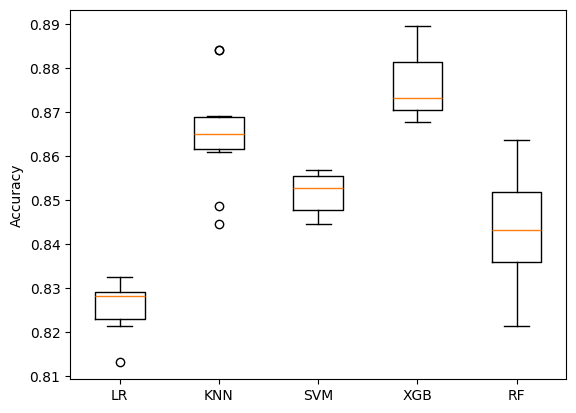

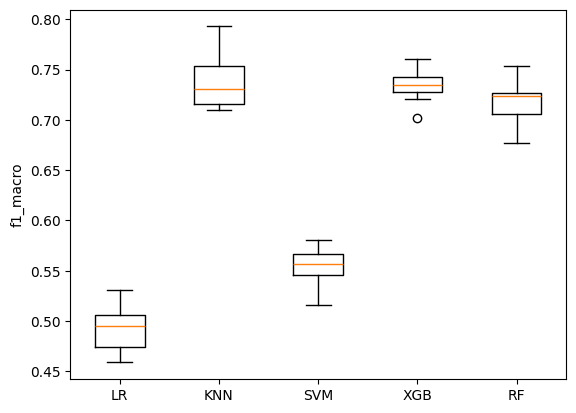

In [9]:
plt.boxplot(results_acc, labels=names)
#plt.title('Algorithm Comparison')
plt.ylabel('Accuracy')
plt.show()
plt.boxplot(results_f1, labels=names)
#plt.title('Algorithm Comparison')
plt.ylabel('f1_macro')
plt.show()

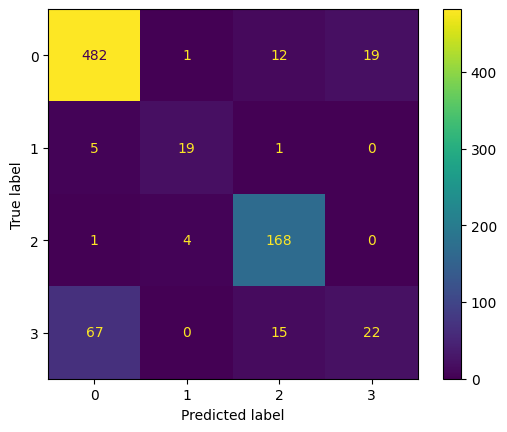

              precision    recall  f1-score   support

           0       0.87      0.94      0.90       514
           1       0.79      0.76      0.78        25
           2       0.86      0.97      0.91       173
           3       0.54      0.21      0.30       104

    accuracy                           0.85       816
   macro avg       0.76      0.72      0.72       816
weighted avg       0.82      0.85      0.82       816



In [10]:
model = xgb.XGBClassifier()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred))

In [11]:
def ensemble_predictions(members, testX):
    yhats = [model.predict(testX) for model in members]
    yhats = np.array(yhats)
    mode = [Counter(col).most_common(1)[0][0] for col in zip(*yhats)]
    return mode

In [12]:
def evaluate_model(trainX, trainy, train_idx):
    clf = xgb.XGBClassifier()
    model = clf.fit(trainX[train_idx][0], trainy[train_idx])
    return model

In [13]:
def evaluate_n_members(members, n_members, testX, testy):
    subset = members[:n_members]
    yhat = ensemble_predictions(subset, testX)
    return yhat, accuracy_score(testy, yhat), f1_score(testy, yhat, average='macro')

In [14]:
n_splits = 100
scores, members = list(), list()
ix = [i for i in range(len(X_train_scaled))]
for j in range(n_splits):    
    train_ix = [resample(ix, replace=True, n_samples=len(X_train_scaled))]
    model = evaluate_model(X_train_scaled, y_train, train_ix)
    members.append(model)

In [15]:
single_accs, ensemble_accs, single_f1s, ensemble_f1s = list(), list(), list(), list()
for i in range(1, n_splits+1):
    _, ensemble_acc, ensemble_f1 = evaluate_n_members(members, i, X_test_scaled, y_test)
    single_acc = accuracy_score(members[i-1].predict(X_test_scaled), y_test)
    single_f1 = f1_score(members[i-1].predict(X_test_scaled), y_test, average='macro')
    print('> %d: single_acc=%f, ensemble_acc=%f' % (i, single_acc, ensemble_acc))
    print('> %d: single_f1=%f, ensemble_f1=%f' % (i, single_f1, ensemble_f1))
    ensemble_accs.append(ensemble_acc)
    single_accs.append(single_acc)
    ensemble_f1s.append(ensemble_f1)
    single_f1s.append(single_f1)

> 1: single_acc=0.829657, ensemble_acc=0.829657
> 1: single_f1=0.696347, ensemble_f1=0.696347
> 2: single_acc=0.838235, ensemble_acc=0.829657
> 2: single_f1=0.715787, ensemble_f1=0.696347
> 3: single_acc=0.822304, ensemble_acc=0.829657
> 3: single_f1=0.690928, ensemble_f1=0.688175
> 4: single_acc=0.834559, ensemble_acc=0.832108
> 4: single_f1=0.704444, ensemble_f1=0.693456
> 5: single_acc=0.846814, ensemble_acc=0.841912
> 5: single_f1=0.739483, ensemble_f1=0.704397
> 6: single_acc=0.830882, ensemble_acc=0.837010
> 6: single_f1=0.699771, ensemble_f1=0.702816
> 7: single_acc=0.832108, ensemble_acc=0.837010
> 7: single_f1=0.703130, ensemble_f1=0.690243
> 8: single_acc=0.829657, ensemble_acc=0.837010
> 8: single_f1=0.701515, ensemble_f1=0.697680
> 9: single_acc=0.844363, ensemble_acc=0.838235
> 9: single_f1=0.711716, ensemble_f1=0.697390
> 10: single_acc=0.834559, ensemble_acc=0.841912
> 10: single_f1=0.725732, ensemble_f1=0.710650
> 11: single_acc=0.830882, ensemble_acc=0.839461
> 11: sin

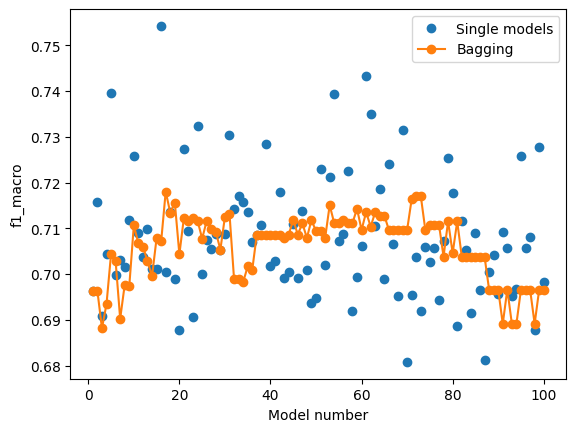

In [16]:
x_axis = [i for i in range(1, n_splits+1)]
plt.plot(x_axis, single_f1s, marker='o', linestyle='None')
plt.plot(x_axis, ensemble_f1s, marker='o')
plt.xlabel('Model number')
plt.ylabel('f1_macro')
plt.legend(['Single models','Bagging'])

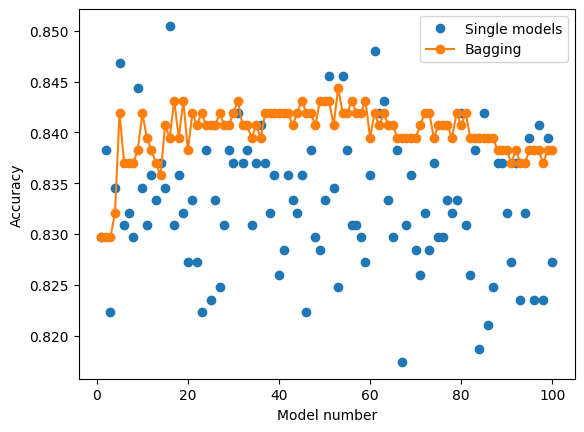

In [17]:
x_axis = [i for i in range(1, n_splits+1)]
plt.plot(x_axis, single_accs, marker='o', linestyle='None')
plt.plot(x_axis, ensemble_accs, marker='o')
plt.xlabel('Model number')
plt.ylabel('Accuracy')
plt.legend(['Single models','Bagging'])

In [18]:
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=col_names)
explainer = shap.Explainer(model.predict, X_test_scaled_df)

In [19]:
X_test_scaled_df.head()

,cpu_milli,memory_mib,num_gpu,gpu_milli,creation_time,qos_BE,qos_LS,qos_Guranteed
0,0.104956,0.374445,0.143615,0.814573,0.924057,-0.848081,0.869404,-0.030905
1,-0.890477,-0.969298,0.143615,0.295239,-0.038987,1.179133,-1.150213,-0.030905
2,-0.890477,-0.969298,0.143615,0.814573,-1.626237,1.179133,-1.150213,-0.030905
3,0.251559,0.627199,-1.443076,-1.918766,-1.131211,-0.848081,0.869404,-0.030905
4,0.251559,0.627199,-1.443076,-1.918766,1.059055,-0.848081,0.869404,-0.030905


In [20]:
shap_values = explainer(X_test_scaled_df)

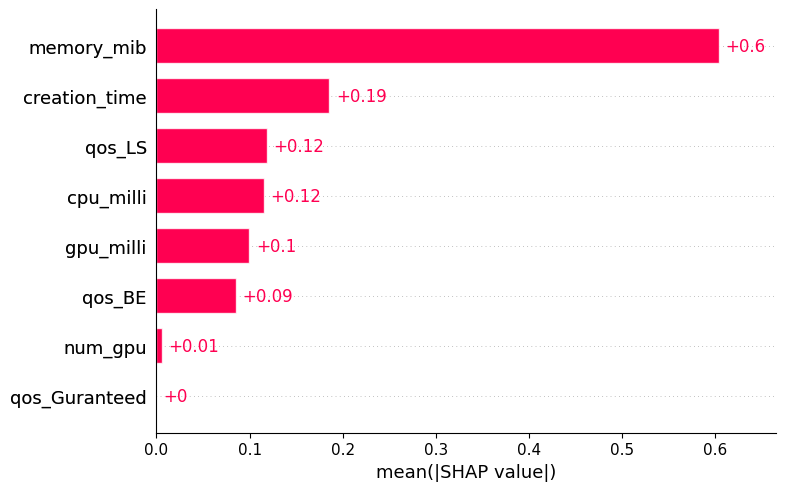

In [21]:
shap.plots.bar(shap_values)

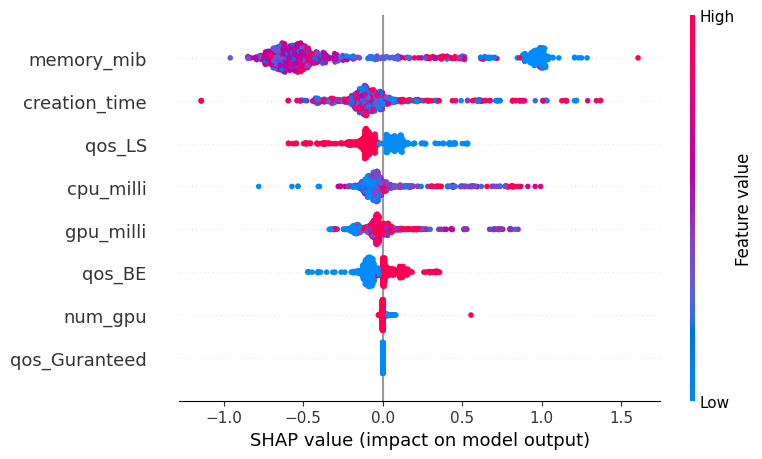

In [22]:
shap.summary_plot(shap_values)

In [25]:
def print_feature_importances_shap_values(shap_values, features):
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
    importances_norm = softmax(importances)
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")

In [26]:
features = ['cpu_milli','memory_mib','num_gpu','gpu_milli','creation_time','qos_BE','qos_LS','qos_Guaranteed',]
print_feature_importances_shap_values(shap_values, features)

memory_mib -> 0.6037 (softmax = 0.1929)
creation_time -> 0.1856 (softmax = 0.1270)
qos_LS -> 0.1188 (softmax = 0.1188)
cpu_milli -> 0.1154 (softmax = 0.1184)
gpu_milli -> 0.0996 (softmax = 0.1165)
qos_BE -> 0.0852 (softmax = 0.1149)
num_gpu -> 0.0059 (softmax = 0.1061)
qos_Guaranteed -> 0.0000 (softmax = 0.1055)
